<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/pytorch_cv_e2e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting Started

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
print(f'torch version: {torch.__version__}')

torch version: 1.3.1


In [0]:
import matplotlib.pyplot as plt
import numpy as np

## Loading the Data

In [0]:
# parameters
BATCH_SIZE = 32
transform = transforms.Compose([
                                transforms.ToTensor()
])

In [0]:
# downlaod data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [0]:
# load data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Exploring the Data

In [29]:
# check first image, label
trainset[0][0][0, :, :].shape, trainset[0][1]

(torch.Size([28, 28]), 5)

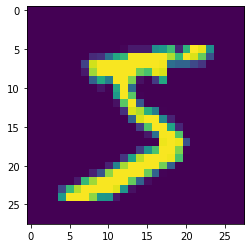

In [30]:
plt.imshow(trainset[0][0][0, :, :]);

In [0]:
# check first batch images, labels
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

(None,
 tensor([6, 3, 8, 1, 4, 9, 1, 6, 2, 5, 8, 2, 4, 2, 5, 4, 3, 8, 9, 0, 0, 0, 7, 2,
         0, 3, 2, 0, 1, 4, 7, 1]))

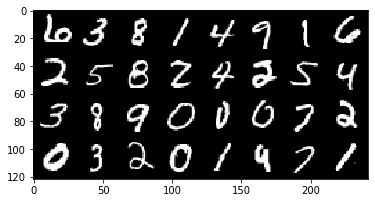

In [33]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images)), labels


In [35]:
# the dimentions of the each batch
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## The Model

In [0]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = nn.Linear(28 * 28, 128)
    self.dropout = nn.Dropout(p=0.2)
    self.d2 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.flatten(start_dim=1)
    x = self.d1(x)
    x = F.relu(x)
    x = self.dropout(x)
    logits = self.d2(x)
    out = F.softmax(logits, dim=1)
    return out

In [45]:
# test model with one batch
model = MyModel()
for images, labels in trainloader:
  print('batch size: {}'.format(images.shape))
  out = model(images)
  print('output size: {}'.format(out.shape))
  break

batch size: torch.Size([32, 1, 28, 28])
output size: torch.Size([32, 10])


## Training the model

In [0]:
learning_rate = 1e-3
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cup')

In [0]:
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# utility function of accuracy for each batch
def get_accuracy(output, target, batch_size):
  corrects = (torch.max(output, dim=1)[1].view(target.size()).data == target.data).sum()
  accuracy = 100. * corrects/batch_size
  return accuracy.item() 


In [63]:
for epoch in range(1, num_epochs+1):
  train_running_loss = 0.0
  train_acc = 0.0
  model = model.train()

  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    loss = criterion(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
  
  model.eval()
  print('Epoch: {:d} | Train Loss: {:.4f} | Train Accuracy: {:.2f}%'.format(epoch, train_running_loss/i, train_acc/i))

Epoch: 1 | Train Loss: 1.5943 | Train Accuracy: 89.03%
Epoch: 2 | Train Loss: 1.5291 | Train Accuracy: 93.94%
Epoch: 3 | Train Loss: 1.5141 | Train Accuracy: 95.31%
Epoch: 4 | Train Loss: 1.5057 | Train Accuracy: 96.04%
Epoch: 5 | Train Loss: 1.5005 | Train Accuracy: 96.48%


In [64]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: {:.2f}%'.format( test_acc/i))

Test Accuracy: 96.67%
